In [1]:
import numpy
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
import pickle
from collections import Counter
from rdkit import rdBase
print(rdBase.rdkitVersion)

import time
print(time.asctime())
%pylab inline

2021.03.1
Wed May 26 09:43:04 2021
Populating the interactive namespace from numpy and matplotlib


In [3]:
from loaders.Loaders import CSVLoader
#Load Dataset
dataset = CSVLoader(dataset_path='data/dataset_last_version2.csv', 
                    mols_field='Smiles', 
                    labels_fields='Class')#, shard_size=4000)
dataset = dataset.create_dataset(sep=';')
dataset.get_shape()

Mols_shape:  2344
Features_shape:  X not defined!
Labels_shape:  (2344,)


In [11]:
from rdkit.Chem import rdMolDescriptors, MolFromSmiles

#Now loop over all the fingerprints and count both the number of bits set in each 
#fingerprint and the number of times each bit is set.

numBitCount = Counter()
fpBitCount = Counter()
for i in range(len(dataset.mols)):
    try :
        mol = MolFromSmiles(dataset.mols[i])
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        numBitCount[fp.GetNumOnBits()]+=1
        for bit in fp.GetOnBits():
            fpBitCount[bit]+=1
    except: pass
    if not i%1000:
        print("Doing: ",i)

Doing:  0


RDKit ERROR: [09:51:17] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [09:51:17] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [09:51:17] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [09:51:17] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [09:51:17] SMILES Parse Error: syntax error while parsing: CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3cc4cc(Oc5ccc(cc5Cl)[C@@H](O)[C@@H]6NC(=O)[C@H](NC(=O)[C@@H]4NC(=O)[C@H](CC(=O)N)NC1=O)c7ccc(O)c(c7)c8c(O)cc(O)cc8[C@H](NC6=O)C(=O)O)c3O[C@@H]9O[C@H](CO)[C@@H](O)[C@H](O)[C@H]9O[C@H]%10C[C@](C)(N)[C@H](O)[C
RDKit ERROR: [09:51:17] SMILES Parse Error: Failed parsing SMILES 'CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3cc4cc(Oc5ccc(cc5Cl)[C@@H](O)[C@@H]6NC(=O)[C@H](NC(=O)[C@@H]4NC(=O)[C@H](CC(=O)N)NC1=O)c7ccc(O)c(c7)c8c(O)cc(O)cc8[C@H](NC6=O)C(=O)O)c3O[C@@H]9O[C@H](CO)[C@@H](O)[C@H](O)[C@H]9O[C@H]%10C[C@](C)(N)[C@H](O)[C' for input: 'C

Doing:  1000


RDKit ERROR: [09:51:17] Explicit valence for atom # 1 Si, 8, is greater than permitted


Doing:  2000


RDKit WARNING: [09:51:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [09:51:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [09:51:17] WARNING: not removing hydrogen atom without neighbors


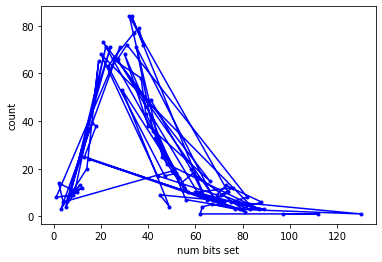

In [12]:
# Start by looking at the histogram of the number of bits set per molecule
plot([x for x,y in numBitCount.items()],[y for x,y in numBitCount.items()],'.b-')
_=xlabel("num bits set")
_=ylabel("count")

In [13]:
min(numBitCount.items()),max(numBitCount.items())
#The minimum number of bits set is 1, this happens 8 times. 
#The maximum number of bits set is 130, and this happens only once.

((1, 8), (130, 1))

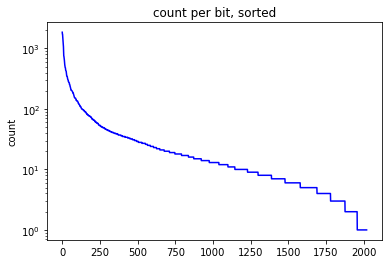

In [17]:
#And the number of times each individual bit is set, but plotted differently so that we can see it:
plot(sorted([y for x,y in fpBitCount.items()],reverse=True),'b-')
_=yscale("log")
_=ylabel("count")
_=title("count per bit, sorted")

In [15]:
#More detailed stats:
[np.percentile(sorted([y for x,y in fpBitCount.items()]),z) for z in (1,25,50,75,99)]

[1.0, 6.0, 13.0, 29.0, 481.7999999999997]

In [16]:
min([y for x,y in fpBitCount.items()]),max([y for x,y in fpBitCount.items()])
#So the least frequently hit bit is found in 1 molecule, the most frequently hit is in 1853

(1, 1853)

In [33]:
#Find an example molecule for each bit

keepMols={}
#toFind = list(set(bitExamples.values()))
bitExamples={}
needed = list(range(2048))
suppl = dataset.mols
mid = 0
for i,m in enumerate(suppl):
    m = MolFromSmiles(m)
    if not m:
        continue
    fp = Chem.GetMorganFingerprintAsBitVect(m,2,2048)
    #mid = m.GetProp('MyProp')
    for bit in fp.GetOnBits():
        if bit in needed:
            bitExamples[bit] = mid
            keepMols[mid]=m
            needed.remove(bit)
            mid+=1
    if not len(needed):
        break
    if not i%100:
        print("Done:",i," left:",len(needed))

Done: 0  left: 2007
Done: 200  left: 896
Done: 300  left: 840


RDKit ERROR: [10:27:36] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:27:36] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [10:27:36] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [10:27:36] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [10:27:36] SMILES Parse Error: syntax error while parsing: CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3cc4cc(Oc5ccc(cc5Cl)[C@@H](O)[C@@H]6NC(=O)[C@H](NC(=O)[C@@H]4NC(=O)[C@H](CC(=O)N)NC1=O)c7ccc(O)c(c7)c8c(O)cc(O)cc8[C@H](NC6=O)C(=O)O)c3O[C@@H]9O[C@H](CO)[C@@H](O)[C@H](O)[C@H]9O[C@H]%10C[C@](C)(N)[C@H](O)[C
RDKit ERROR: [10:27:36] SMILES Parse Error: Failed parsing SMILES 'CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3cc4cc(Oc5ccc(cc5Cl)[C@@H](O)[C@@H]6NC(=O)[C@H](NC(=O)[C@@H]4NC(=O)[C@H](CC(=O)N)NC1=O)c7ccc(O)c(c7)c8c(O)cc(O)cc8[C@H](NC6=O)C(=O)O)c3O[C@@H]9O[C@H](CO)[C@@H](O)[C@H](O)[C@H]9O[C@H]%10C[C@](C)(N)[C@H](O)[C' for input: 'C

Done: 400  left: 747
Done: 500  left: 475
Done: 600  left: 307
Done: 700  left: 248
Done: 800  left: 218
Done: 900  left: 190
Done: 1000  left: 170
Done: 1100  left: 151
Done: 1200  left: 131
Done: 1300  left: 104


RDKit WARNING: [10:27:36] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [10:27:36] Explicit valence for atom # 1 Si, 8, is greater than permitted


Done: 1400  left: 91
Done: 1500  left: 75
Done: 1600  left: 66
Done: 1700  left: 53
Done: 1800  left: 48
Done: 1900  left: 38
Done: 2000  left: 33
Done: 2100  left: 31
Done: 2200  left: 31
Done: 2300  left: 27


RDKit WARNING: [10:27:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:27:37] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [10:27:37] WARNING: not removing hydrogen atom without neighbors


In [31]:
#Now let's look at the most commonly and least commonly set bits
itms = [(y,x) for x,y in fpBitCount.items()]

# Functions for providing detailed descriptions of MFP bits from Nadine Schneider 
#  It's probably better to do this using the atomSymbols argument but this does work.
def includeRingMembership(s, n):
    r=';R]'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])
 
def includeDegree(s, n, d):
    r=';D'+str(d)+']'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])
 
def writePropsToSmiles(mol,smi,order):
    #finalsmi = copy.deepcopy(smi)
    finalsmi = smi
    for i,a in enumerate(order):
        atom = mol.GetAtomWithIdx(a)
        if atom.IsInRing():
            finalsmi = includeRingMembership(finalsmi, i+1)
        finalsmi = includeDegree(finalsmi, i+1, atom.GetDegree())
    return finalsmi
 
def getSubstructSmi(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    smi = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,allHsExplicit=True, allBondsExplicit=True, rootedAtAtom=atomID)
    order = eval(mol.GetProp("_smilesAtomOutputOrder"))
    smi2 = writePropsToSmiles(mol,smi,order)
    return smi,smi2

In [32]:
# Least commonly set bits:

for bCount,bitId in sorted(itms)[:20]:
    zid = bitExamples[bitId]
    if zid in keepMols:
        info={}
        fp = Chem.GetMorganFingerprintAsBitVect(keepMols[zid],2,2048,bitInfo=info)
        aid,rad = info[bitId][0]
        smi1,smi2 = getSubstructSmi(keepMols[zid],aid,rad)
        print(bitId,zid,rad,smi2,bCount)

21 1977 2 [O;R;D2]1-[CH;R;D3](-[CH;R;D3])-[CH;R;D3]-1-[C;R;D4] 1
52 1963 1 [O;D2](-[CH2;D2])-[S;D3] 1
96 1397 2 [C;R;D3](-[C;D3](=[O;D1])-[O;D2])(=[C;R;D3](-[CH2;R;D2])-[CH2;D2])-[N;R;D3](-[C;R;D3])-[CH;R;D3] 1
111 1988 2 [C;R;D3](=[O;D1])(-[CH2;R;D2]-[C;R;D4])-[CH;R;D3](-[C;R;D3])-[CH;R;D3] 1
122 2003 2 [CH2;D2](-[CH;R;D3](-[CH2;R;D2])-[C;R;D4])-[N;D3](-[CH3;D1])-[CH3;D1] 1
124 1836 2 [cH;R;D2](:[c;R;D3](:[cH;R;D2])-[CH;R;D3]):[c;R;D3](=[O;D1]):[o;R;D2] 1
129 1523 2 [CH2;R;D2](-[CH;R;D3](-[C;R;D3])-[CH3;D1])-[C;R;D4](-[CH;R;D3])(-[CH3;D1])-[OH;D1] 1
134 1945 2 [CH;D2](=[CH;D2]-[CH;D3])-[CH;R;D3](-[C;R;D3])-[C;R;D4] 1
138 1864 2 [S;D3](=[O;D1])(-[CH;D2]=[CH2;D1])-[CH;D2]=[CH2;D1] 1
163 2001 2 [CH2;R;D2](-[CH;R;D3](-[CH;R;D3])-[N;R;D3])-[CH;R;D3](-[CH2;R;D2])-[O;D2] 1
261 1234 1 [O+;D1]#[C-;D1] 1
355 2000 1 [CH;D3](-[CH;D2])(-[CH;D2])-[OH;D1] 1
356 1711 2 [NH;R;D2](-[C;R;D3](-[CH;R;D3])=[O;D1])-[CH;R;D3](-[C;R;D3])-[CH;R;D3] 1
410 1331 1 [C;D3](-[NH2;D1])(-[NH2;D1])=[O;D1] 1
420 551 2 [

In [34]:
# Most commonly set bits:

for bCount,bitId in sorted(itms)[-20:]:
    zid = bitExamples[bitId]
    if zid in keepMols:
        info={}
        fp = Chem.GetMorganFingerprintAsBitVect(keepMols[zid],2,2048,bitInfo=info)
        aid,rad = info[bitId][0]
        smi1,smi2 = getSubstructSmi(keepMols[zid],aid,rad)
        print(bitId,zid,rad,smi2,bCount)

1257 118 1 [OH;D1]-[CH;R;D3] 488
314 269 1 [O;D1]=[C;R;D3] 515
1199 69 2 [cH;R;D2](:[cH;R;D2]:[c;R;D3]):[cH;R;D2]:[cH;R;D2] 526
875 61 1 [cH;R;D2](:[c;R;D3]):[c;R;D3] 537
294 181 1 [CH3;D1]-[CH2;D2] 600
1 0 0 [CH;D3] 645
389 8 1 [OH;D1]-[C;D3] 658
926 62 0 [CH2;R;D2] 710
656 52 0 [O;R;D2] 742
1088 67 1 [cH;R;D2](:[cH;R;D2]):[cH;R;D2] 752
1019 64 0 [CH;R;D3] 844
1750 80 1 [cH;R;D2](:[c;R;D3]):[cH;R;D2] 1061
1917 39 1 [O;D1]=[C;D3] 1147
695 15 0 [O;D2] 1287
1873 87 0 [cH;R;D2] 1337
80 4 0 [CH2;D2] 1519
1380 74 0 [c;R;D3] 1575
1057 26 0 [CH3;D1] 1719
650 13 0 [O;D1] 1728
807 19 0 [C;D3] 1853


In [35]:
#Visualize the results
# Start by importing some code to allow the depiction to be used:
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

# a function to make it a bit easier. This should probably move to somewhere in
# rdkit.Chem.Draw
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc


def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

In [57]:
def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse,highlightAtomColors={atomID:(0.3,0.3,1)})


def depictBit(bitId,examples,mols,molSize=(450,200)):
    zid = examples[bitId]
    print(zid)
    info={}
    print(Chem.MolToSmiles(mols[zid]))
    fp = Chem.GetMorganFingerprintAsBitVect(mols[zid],2,2048,bitInfo=info)
    print(info)
    aid,rad = info[bitId][0]
    print(aid, rad)
    return getSubstructDepiction(mols[zid],aid,rad,molSize=molSize)

1504
O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F)cc1
{45: ((7, 1),), 80: ((16, 0), (17, 0), (18, 0)), 90: ((24, 2),), 119: ((12, 1),), 221: ((14, 2),), 254: ((5, 2),), 314: ((15, 1),), 463: ((2, 2),), 581: ((5, 1),), 637: ((3, 2),), 650: ((15, 0), (20, 0)), 653: ((16, 2),), 699: ((27, 1),), 758: ((14, 1),), 807: ((19, 0),), 926: ((0, 0), (1, 0), (3, 0)), 935: ((2, 0), (6, 0)), 987: ((13, 2),), 1058: ((18, 2),), 1088: ((9, 1), (10, 1)), 1104: ((0, 2),), 1114: ((13, 0),), 1145: ((16, 1),), 1199: ((9, 2), (10, 2)), 1285: ((8, 2),), 1333: ((3, 1),), 1357: ((7, 2),), 1380: ((5, 0), (7, 0), (12, 0), (14, 0), (21, 0), (24, 0)), 1385: ((21, 1),), 1410: ((23, 2), (25, 2)), 1451: ((19, 2),), 1480: ((1, 1),), 1490: ((6, 2),), 1526: ((1, 2),), 1564: ((18, 1),), 1587: ((12, 2),), 1592: ((4, 2),), 1618: ((21, 2),), 1670: ((24, 1),), 1693: ((19, 1),), 1697: ((22, 2), (26, 2)), 1738: ((0, 1),), 1745: ((13, 1),), 1750: ((8, 1), (11, 1), (22, 1), (23, 1), (25, 1), (26, 1)), 1781: ((4, 1),), 1783: ((1

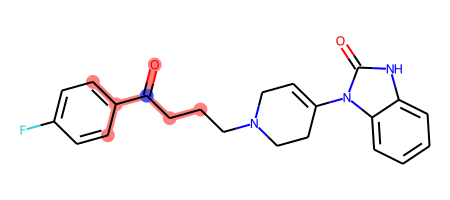

In [63]:
bCount,bitId = sorted(itms)[215]

depictBit(bitId,bitExamples,keepMols)

In [56]:
sorted(itms)

bitExamples

#keepMols

{1: 0,
 32: 1,
 54: 2,
 70: 3,
 80: 4,
 116: 5,
 117: 6,
 147: 7,
 389: 8,
 508: 9,
 573: 10,
 592: 11,
 623: 12,
 650: 13,
 667: 14,
 695: 15,
 736: 16,
 739: 17,
 786: 18,
 807: 19,
 841: 20,
 890: 21,
 948: 22,
 968: 23,
 1017: 24,
 1035: 25,
 1057: 26,
 1141: 27,
 1152: 28,
 1162: 29,
 1171: 30,
 1230: 31,
 1283: 32,
 1290: 33,
 1393: 34,
 1547: 35,
 1737: 36,
 1849: 37,
 1911: 38,
 1917: 39,
 2016: 40,
 94: 41,
 125: 42,
 140: 43,
 162: 44,
 191: 45,
 227: 46,
 249: 47,
 404: 48,
 429: 49,
 609: 50,
 613: 51,
 656: 52,
 715: 53,
 750: 54,
 753: 55,
 757: 56,
 769: 57,
 802: 58,
 838: 59,
 843: 60,
 875: 61,
 926: 62,
 942: 63,
 1019: 64,
 1025: 65,
 1077: 66,
 1088: 67,
 1195: 68,
 1199: 69,
 1236: 70,
 1274: 71,
 1279: 72,
 1338: 73,
 1380: 74,
 1481: 75,
 1536: 76,
 1542: 77,
 1708: 78,
 1729: 79,
 1750: 80,
 1755: 81,
 1758: 82,
 1803: 83,
 1809: 84,
 1814: 85,
 1816: 86,
 1873: 87,
 1905: 88,
 1963: 89,
 1970: 90,
 1996: 91,
 35: 92,
 55: 93,
 184: 94,
 222: 95,
 223: 96,
 267